# Post-processing of single interferogram from `topsStack`

+ `run_isce_stack.py` to generate the single interferogram using `isce2/topsStack`
+ `prep_isce.py` to generate metadata files
+ re-run `unwrap.py` to re-unwrap the interferogram with custom mask that includes the fault rupture, as a guide.
+ `load_data.py` to write the `geometryRadar.h5` file

```bash
cd ~/data/archives/2021MaduoEQ/SenAT099/merged/interferograms/20210520_20210526
generate_mask.py filt_mli.unw.conncomp -m 0.5 -M 1.5 -o maskConnComp.h5
mask.py filt_mli.unw -m maskConnComp.h5 -o filt_msk.unw
geocode.py filt_msk.unw -l ../../../mintpy/inputs/geometryRadar.h5 -o geo_filt_msk.unw

# edit custom template file for geometry file path
mkdir -p mintpy; cd mintpy
load_data.py -t MaduoSenAT099.txt

```

In [2]:
%matplotlib inline
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

import mintpy
import mintpy.workflow
import mintpy.tropo_pyaps3
from mintpy.utils import ptime, readfile, writefile
from mintpy.add_attribute import update_file_attribute
plt.rcParams.update({'font.size': 12})

proj_dir = os.path.expanduser('~/data/archives/2021MaduoEQ/SenAT099')
#proj_dir = os.path.expanduser('~/data/archives/2021MaduoEQ/SenDT106')

S, N, W, E = 33.2, 35.9, 96.6, 100.1  # output bounding box in lat/lon
step = 0.000833334                # degrees, ~90 m
ref_lat, ref_lon = 34.2, 97.3     # degrees

work_dir = os.path.join(proj_dir, 'merged/interferograms/20210520_20210526')
os.chdir(work_dir)
print('Go to directory:', work_dir)
geom_file = os.path.join(proj_dir, 'mintpy/inputs/geometryRadar.h5')
dem_file = glob.glob(os.path.join(proj_dir, '../DEM/demLat*.dem'))[0]

Go to directory: /Users/yunjunz/data/archives/2021MaduoEQ/SenAT099/merged/interferograms/20210520_20210526


## 1. Post-processing: mask + geocode + referencing

In [78]:
# 1. mask out pixels with potential phase unwrapping error
mintpy.generate_mask.main('filt_mli.unw.conncomp -m 0.5 -M 1.5 -o maskConnComp.h5'.split())
mintpy.mask.main('filt_mli.unw -m maskConnComp.h5 -o filt_msk.unw'.split())

# 2. add more metadata from XML file
atr = readfile.read_roipac_rsc(os.path.join(proj_dir, 'reference/data.rsc'))
atr['DATE12'] = ptime.yymmdd_date12(os.path.basename(work_dir))
update_file_attribute('filt_msk.unw', atr)

# 3. geocode
opt = f'-l {geom_file} --lalo -{step} {step} -b {S} {N} {W} {E} '
mintpy.geocode.main(f'filt_msk.unw -o geo_filt_msk.unw {opt}'.split())
mintpy.geocode.main(f'filt_mli.cor -o geo_filt_msk.cor {opt}'.split())
mintpy.geocode.main(f'../../geom_reference/los.rdr -o los.geo {opt}'.split())
mintpy.geocode.main(f'../../../mintpy/inputs/geometryRadar.h5 -o geometryGeo.h5 {opt} --update'.split())

# 4. spatial referencing
cmd = f'geo_filt_msk.unw --lat {ref_lat} --lon {ref_lon} --write-data'
mintpy.reference_point.main(cmd.split())

input .conncomp file: filt_mli.unw.conncomp
read filt_mli.unw.conncomp
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.5
exclude pixels with value > 1.5
delete exsited file: maskConnComp.h5
create HDF5 file: maskConnComp.h5 with w mode
create dataset /mask of bool       in size of (3449, 3803)         with compression=None
finished writing to maskConnComp.h5
time used: 00 mins 0.5 secs.
masking magnitude from filt_mli.unw ...
masking phase     from filt_mli.unw ...
write file: filt_msk.unw
write file: filt_msk.unw.rsc
Done.
update .unw file attribute: filt_msk.unw
writing >>> filt_msk.unw.rsc
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/yunjunz/data/archives/2021MaduoEQ/SenAT099/mintpy/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000833334, 0.000833334)
output area extent in (S, N, W, E) in degree: (33.1

## 2. Noise reduction and uncertainty quantification (UQ)

### 2.1 Correct for tropospheric delay 

In [6]:
mintpy.tropo_pyaps3.main('-f geo_filt_msk.unw -g geometryGeo.h5'.split())

weather model: ERA5 - dry (hydrostatic) and wet delay
weather directory: /Users/yunjunz/data/aux
output tropospheric delay file: ERA5.h5
output corrected time-series file: geo_filt_msk_ERA5.unw
read dates/time info from file: geo_filt_msk.unw
time of cloest available product: 23:00 UTC

------------------------------------------------------------------------------
downloading weather model data using PyAPS ...
common file size: 759240 bytes
number of grib files existed    : 2
number of grib files to download: 0
------------------------------------------------------------------------------

update mode: ON
output file: ERA5.h5
1) output file exists and is newer than all GRIB files.
2) output file has the same len/wid as the geometry file and contains all dates
3) output file is fully written.
run or skip: skip

------------------------------------------------------------------------------
correcting relative delay for input interferogram
read phase from geo_filt_msk.unw
calc tropospheri

### 2.2 Calculate displacement STD

invalid pixel: 4830334
invalid pixel: 4830334
write file: ifgramStd.geo
write file: ifgramStd.geo.rsc
view.py ifgramStd.geo -u cm --noverbose


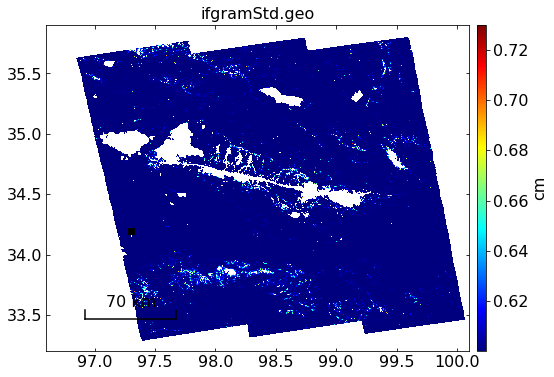

In [79]:
from mintpy.simulation import decorrelation as decor, variance as var
from mintpy.objects import deramp
from mintpy.utils import utils as ut
# read data / mask
unw, atr = readfile.read('geo_filt_msk_ERA5.unw', datasetName='phase')
cor = readfile.read('geo_filt_msk.cor')[0]
mask = np.isnan(unw)
print(f'invalid pixel: {np.sum(mask)}')
mask[np.isnan(cor)] = 1
mask[cor == 0] = 1
print(f'invalid pixel: {np.sum(mask)}')
cor[mask] = 0
L = 3 * 9
phase2range = float(atr['WAVELENGTH']) / (4 * np.pi)

# calc STD
std_decor = np.sqrt(decor.coherence2phase_variance(cor, L, coh_step=0.01)) * phase2range * 100.
std_decor[mask] = np.nan
std_tropo = 0.6 if os.path.basename(proj_dir) == 'SenAT099' else 1.2  # from structral function
ifg_std = np.sqrt(std_tropo**2 + std_decor**2).astype(np.float32)

# write to file
atr['FILE_TYPE'] = 'displacement'
atr['DATA_TPYE'] = 'float32'
atr['BANDS'] = '1'
atr['UNIT'] = 'm'
writefile.write(ifg_std/100., out_file='ifgramStd.geo', metadata=atr)

# plot
mintpy.view.main('ifgramStd.geo -u cm --noverbose'.split())

### 2.3 Calculate structral function for tropospheric delay STD

+ Asc: 0.6 cm
+ Desc: 1.2 cm

[==================================================]    3s /     0s 
[==================================================]    0s /     0s 


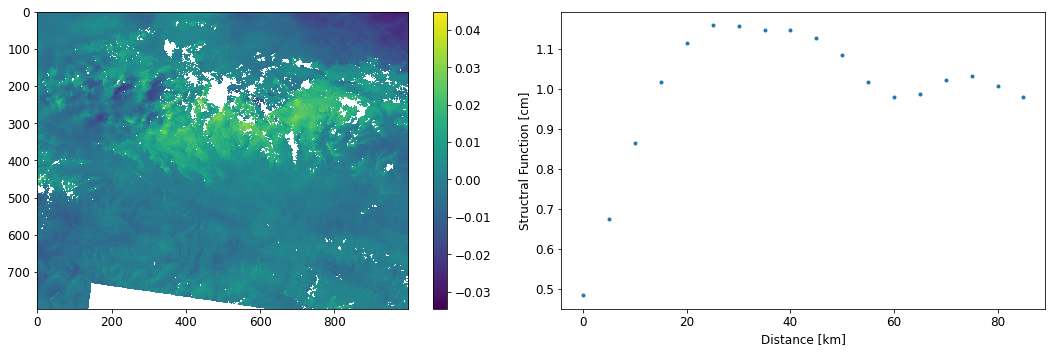

In [72]:
# read displacement, convert to meter, deramp
box = (1000, 2200, 2000, 3000)
dis, atr = readfile.read('geo_filt_msk_ERA5.unw', datasetName='phase', box=box)
dis *= float(atr['WAVELENGTH']) / (4. * np.pi)
dis_ramp = deramp(dis)[0]

# calculate
lats, lons = ut.get_lat_lon(atr, box=box)
idx_sample, lat_sample, lon_sample = var.sample_data(lats, lons, mask=~np.isnan(dis_ramp), num_sample=2e3)
dis_sample = dis_ramp.flatten()[idx_sample]
(bin_dist,
 bin_struct_func,
 bin_struct_func_std) = var.structure_function(dis_sample, lat_sample, lon_sample, step=5e3, min_pair_num=1e4)

# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])
ax = axs[0]
im = ax.imshow(dis_ramp, interpolation='nearest')
fig.colorbar(im, ax=ax)
ax = axs[1]
ax.plot(bin_dist/1000, np.sqrt(bin_struct_func)*100, '.')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Structral Function [cm]')
fig.tight_layout()
plt.show()

### 2.4 Write ISCE metadata files

In [75]:
# write ISCE xml/vrt files
for fname in ['geo_filt_msk_ERA5.unw', 'ifgramStd.geo', 'los.geo']:
    atr = readfile.read_attribute(fname)
    writefile.write_isce_xml(atr, fname)

write file: geo_filt_msk_ERA5.unw.xml
write file: geo_filt_msk_ERA5.unw.vrt
write file: ifgramStd.geo.xml
write file: ifgramStd.geo.vrt
write file: los.geo.xml
write file: los.geo.vrt


## 3. Plot

view.py geo_filt_msk.unw phase -v -1 1 --math reverse -c RdBu -u m --dem /Users/yunjunz/data/archives/2021MaduoEQ/SenAT099/../DEM/demLat_N33_N36_Lon_E096_E101.dem --notitle --lalo-label --cbar-nbins 5 --cbar-ext both --cbar-label phase [m]
run view.py in MintPy version v1.3.2-31, date 2022-02-08
input file is isce .unw file: /Users/yunjunz/data/archives/2021MaduoEQ/SenAT099/merged/interferograms/20210520_20210526/geo_filt_msk.unw in float32 format
file size in y/x: (3240, 4200)
input dataset: "['phase']"
num of datasets in file geo_filt_msk.unw: 2
datasets to exclude (0):
[]
datasets to display (1):
['phase']
data   coverage in y/x: (0, 0, 4200, 3240)
subset coverage in y/x: (0, 0, 4200, 3240)
data   coverage in lat/lon: (96.6, 35.9, 100.1000028, 33.19999784)
subset coverage in lat/lon: (96.6, 35.9, 100.1000028, 33.19999784)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cart

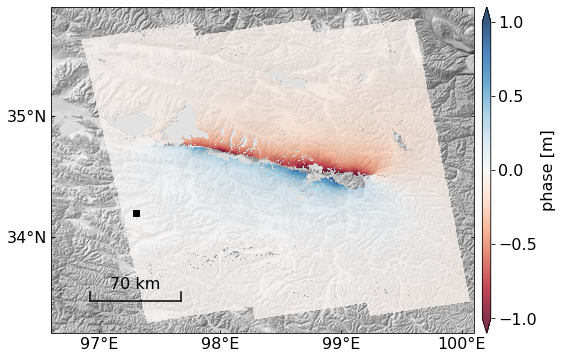

In [2]:
out_fig = '{}_{}_phase.png'.format(os.path.basename(proj_dir), os.path.basename(work_dir))
cmd = f'geo_filt_msk_ERA5.unw phase -v -1 1 --math reverse -c RdBu -u m --dem {dem_file} '
cmd += ' --notitle --lalo-label --cbar-nbins 5 --cbar-ext both '
#cmd += f' -o {out_fig} '
iargs = cmd.split() + ['--cbar-label', 'phase [m]']
print('view.py ' + ' '.join(iargs))
mintpy.view.main(iargs)

### Backups: InSAR vs. SAR range offset

In [3]:
from skimage.transform import resize
proj_name = 'SenAT099' #'SenAT099' # 'SenDT106'
unw_file = f'/Users/yunjunz/data/archives/2021MaduoEQ/{proj_name}/merged/interferograms/20210520_20210526/geo_filt_msk_ERA5.unw'
off_file = f'/Users/yunjunz/data/archives/2021MaduoEQ/{proj_name}/merged/offsets/20210520_20210526/rgOff.geo'

In [13]:
# read InSAR
unw, atr = readfile.read(unw_file, datasetName='phase')
unw *= float(atr['WAVELENGTH']) / (4 * np.pi)
unw -= unw[int(atr['REF_Y']), int(atr['REF_X'])]
# read / resize offset
off, atr_off = readfile.read(off_file)
off2 = resize(off, unw.shape, order=1, mode='edge', preserve_range=True)
# calculuate difference
diff = unw - off2
diff -= np.nanmean(diff)

save figure to file /Users/yunjunz/data/archives/2021MaduoEQ/SenAT099_pha_vs_off.png


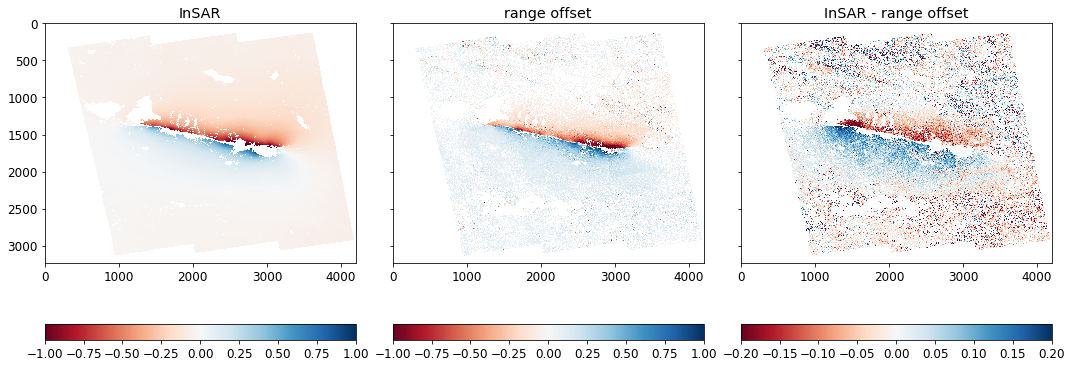

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharey=True)
for ax, data, vlim, title in zip(axs, [unw, off2, diff], [1,1,0.2], ['InSAR', 'range offset', 'InSAR - range offset']):
    im = ax.imshow(data, vmin=-vlim, vmax=vlim, cmap='RdBu', interpolation='nearest')
    ax.set_title(title)
    fig.colorbar(im, ax=ax, location='bottom')
fig.tight_layout()

# output
out_fig = os.path.join(os.path.dirname(proj_dir), f'{proj_name}_pha_vs_off.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

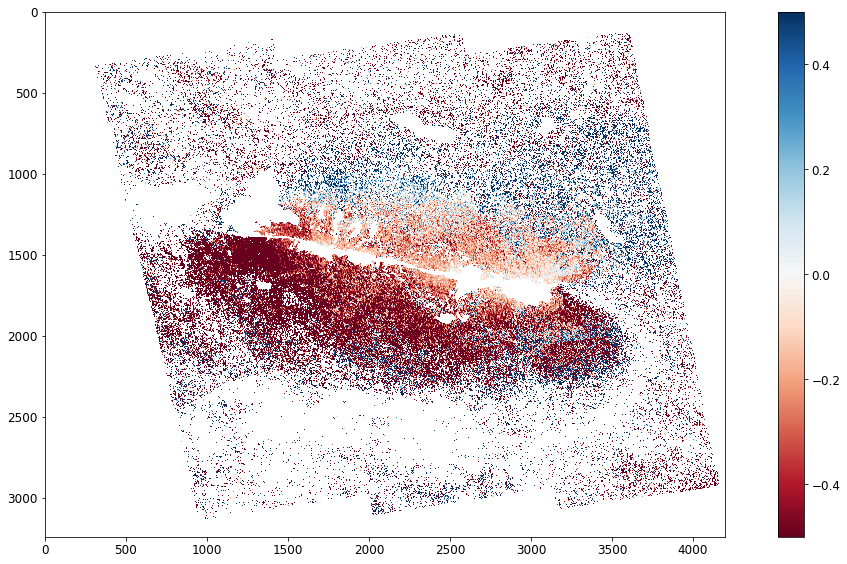

In [22]:
# plot the ratio of (off - insar) / insar
y0, y1 = 2500, 2800
x0, x1 = 1500, 2000

unw_ref = unw - np.nanmedian(unw[y0:y1,x0:x1])
off_ref = off2 - np.nanmedian(off2[y0:y1,x0:x1])
ratio = (off_ref - unw_ref) / unw_ref
ratio[np.abs(ratio) > 2] = np.nan

fig, ax = plt.subplots(figsize=[15, 8])
im = ax.imshow(ratio, vmin=-0.5, vmax=0.5, cmap='RdBu', interpolation='nearest')
fig.colorbar(im)
fig.tight_layout()
plt.show()